# Power Budget Worksheet

_An estimate of potential running time for this system._


### Power Budget

Average Runtime is approx. 57 seconds without modem, and approx. 78 seconds with modem.

$$
\textbf{Estimated Battery Life (100\% available)} = 
\frac{\text{Battery Capacity (mAh)} \times 1.00}{\text{Hourly Consumption (mA)}} \times (1.0 - \text{Battery Discharge Safety})
$$

$$
\textbf{Estimated Battery Life (75\% available due to LDO dropout)} = 
\frac{\text{Battery Capacity (mAh)} \times 0.75}{\text{Hourly Consumption (mA)}} \times (1.0 - \text{Battery Discharge Safety})
$$

[Battery being tested: XTAR 18650, 2600mAh, 3.7V, 9.62Wh](https://www.xtar.cc/product/xtar-18650-2600mah-battery-69.html)

__There is no data sheet for this specific battery.__

- This table contains integrated components.

* Note: I am assuming, because I am simply powering off the modem using modem.poweroff() [it is a software powerdown], that the modem will continue to leak current. I am not holding PWRKEY low or using any pin manipulation to force a hardware shutoff.

| Mode | Current (mA) | Duration per Run |
| -: | -: | -: |
| Deep Sleep | 0.015mA (worst case) | 21600 sec |
| Active (Measurement Mode, No GSM TX) | 100mA | 80 sec |
| Modem Burst (Peak) | 700mA | 5 sec |
| Modem Transmit | 250mA | 25 sec |
| Modem Sleep | 1mA | 21600 sec | 
| Write to SD Burst | 200mA | 1 sec |
| Write to SD | 100mA | 3 sec |

- This table contains separate components.

| Peripheral | Voltage | Current (mA) |	Active Time (sec/day) |
| -: | -: | -: | -: |
| DFRobot pH Sensor | 3.3V | 4mA |	5 sec |
| Grove TDS Sensor | 3.3V |	4mA	| 5 sec |
| DS18B20 Temp Sensor |	3.3V |	1.5mA |	5 sec |
| RTC Standby |	3.3V | 0.11mA |	21600 sec |
| RTC Active | 3.3V | 0.2mA	| 1 sec |
| ADC PH Active| 3.3V | 0.15mA	| 80 sec |
| ADC TDS Active | 3.3V | 0.15mA | 80 sec |
| ADC PH Standby| 3.3V | 0.15mA	| 21600 sec |
| ADC TDS Standby | 3.3V | 0.15mA| 21600 sec |


__I have run calculations in code blocks below. Here are the results of those calculations.__

```
The total active draw over time for one run is 5.09 mAh.
The total sleep draw over time for one cycle is 8.55 mAh.
The total draw in a 6.02222 hour (one full active and deep sleep) cycle is 13.64 mAh (5.09 mAh + 8.55 mAh).
The average consumption is 2.26 mA.

The estimated "best case" battery life (accounting for 100% charge available, 20% safety margin) is,
918.39 hours, or 38.27 days.
The estimated "likely case" battery life (accounting for 75% charge available, 20% safety margin) is,
688.79 hours, or 28.70 days.

```

In [17]:
# Saves the figures in the images/results directory
from pathlib import Path
import emoji

IMAGES_PATH = Path() / "images" / "results"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

print(emoji.emojize(":check_mark_button:"))

✅


In [18]:
# Power Budget Calculator
# current units are in mA
import numpy as np
import matplotlib.pyplot as plt

# define power consumption in mA
deep_sleep = 0.015 # datasheet says 10 μA (0.010 mA), but we will assume 15 μA (0.015 mA)
active_mode = 100 # 100 mA, ESP32 (only) measurement (or "active" mode), when the controller is running
modem_mode_burst = 700 # 700 mA of additional spike when the modem powers up, 100 mA base current already account for
modem_mode = 250 # 250 mA of additional current when the modem is transmitting, 100 mA base current already account for
modem_sleep = 1.0 # 1.0 mA, modem standby current, additional current when the modem is active
storage_mode_burst = 200 # 200 mA of extra current when the SD Card module powers up, 100 mA base current already account for
storage_mode = 100 # 100 mA of extra current when the SD Card module is writing, 100 mA base current already account for
ph_sensor = 4 # 4 mA, pH sensor, additional current when the sensor is active
tds_sensor = 4 # 4 mA, TDS sensor, additional current when the sensor is active
temp_sensor = 1.5 # 1.5 mA, temperature sensor, additional current when the sensor is active
rtc_standby = 0.11 # 0.11 mA, RTC standby current, additional current when the RTC is active
rtc_active = 0.2 # 0.2 mA, RTC active current, additional current when the RTC is active
adc1_active = 0.15 # 0.15 mA, ADC1 active current, additional current when the ADC is active
adc2_active = 0.15 # 0.15 mA, ADC2 active current, additional current when the ADC is active

# We need to define component active times in seconds, totaled for one day
# Overall, we are doing 4 measurements per day, 4 transmissions per day, 4 deep sleep periods per day
# and 4 storage periods per day.
# Let's begin with calculating the time each component is active in one cycle.
active_mode_time = 80 # 80 seconds, ESP32 (only) active mode
modem_mode_burst_time = 5 # 5 seconds, ESP32 (only) transmit mode, when the modem turns on
modem_mode_time = 25 # 25 seconds, ESP32 (only) transmit mode, when the modem is transmitting
storage_mode_burst_time = 1 # 3 seconds, ESP32 (only) storage mode, when the SD Card module turns on
storage_mode_time = 3 # 3 seconds, ESP32 (only) storage mode, when the SD Card module is writing
ph_sensor_time = 5 # 5 seconds, pH sensor active time, sensor is active for ~4-5 seconds per measurement
tds_sensor_time = 5 # 5 seconds, TDS sensor active time, sensor is active for ~4-5 seconds per measurement
temp_sensor_time = 5 # 5 seconds, temperature sensor active time, sensor is active for ~4-5 seconds per measurement
rtc_active_time = 1 # 4 seconds, RTC active time, RTC is active for ~1 second per system run
adc1_active_time = 80 # 80 seconds, ADC1 active time
adc2_active_time = 80 # 80 seconds, ADC2 active time

# These are the deep sleep costs, which are not included in "active time". This is one cycle, lasting 6 hours.
# We are doing 4 deep sleep cycles per day.
deep_sleep_time = 360 * 60 # 21600 seconds, deep sleep time
modem_sleep_time = 360 * 60 # 21600 seconds, modem sleep time
rtc_standby_time = 360 * 60 # 21600 seconds, RTC standby time
adc1_standby_time = 360 * 60 # 21600 seconds, ADC1 standby time
adc2_standby_time = 360 * 60 # 21600 seconds, ADC2 standby time

# Let's print the variables
print('These components are active for "x" seconds per 1 device cycle @ "y" mA.\n',
        '\n',
        
        f'Active mode time: {active_mode_time} seconds @ {active_mode} mA\n',
        f'Transmit mode burst time: {modem_mode_burst_time} seconds @ {modem_mode_burst} mA\n',
        f'Transmit mode time: {modem_mode_time} seconds @ {modem_mode} mA\n',
        f'Storage mode burst time: {storage_mode_burst_time} seconds @ {storage_mode_burst} mA\n',
        f'Storage mode time: {storage_mode_time} seconds @ {storage_mode} mA\n',
        f'pH sensor time: {ph_sensor_time} seconds @ {ph_sensor} mA\n',
        f'TDS sensor time: {tds_sensor_time} seconds @ {tds_sensor} mA\n',
        f'Temperature sensor time: {temp_sensor_time} seconds @ {temp_sensor} mA\n',
        f'RTC active time: {rtc_active_time} seconds @ {rtc_active} mA\n',
        f'ADC1 active time: {adc1_active_time} seconds @ {adc1_active} mA\n',
        f'ADC2 active time: {adc2_active_time} seconds @ {adc2_active} mA\n',
        f'\nThe power draw for "x" seconds per 1 deep sleep cycle @ "y" mA.\n',
        f'Deep sleep time: {deep_sleep_time} seconds ({deep_sleep_time/3600:.2f} hours) @ {deep_sleep} mA\n',
        f'Modem sleep time (software power off): {modem_sleep_time} seconds ({modem_sleep_time/3600:.2f} hours) @ {modem_sleep} mA\n',
        f'RTC standby time: {rtc_standby_time} seconds ({rtc_standby_time/3600:.2f} hours) @ {rtc_standby} mA\n',
        f'ADC1 standby time: {adc1_standby_time} seconds ({adc1_standby_time/3600:.2f} hours) @ {adc1_active} mA\n',
        f'ADC2 standby time: {adc2_standby_time} seconds ({adc2_standby_time/3600:.2f}) @ {adc2_active} mA\n')

# define time conversions
seconds_per_minute = 60
minutes_per_hour = 60
hours_per_day = 24

# set the battery capacity in mAh
battery_capacity = 2600

# set the battery voltage in V
battery_voltage = 3.7

# set the battery energy in Wh
# we will convert mWh to Wh, so we divide by 1000
battery_energy = battery_capacity * battery_voltage / 1000 # ~9.62 Wh, 3.7 V * 2600 mAh, 1 Wh = 1000 mWh

# set the battery safety margin
battery_safety_margin = 0.2 # 20% safety margin

# create arrays for active and sleep power consumption

power_array_active = np.array([
    active_mode,
    modem_mode_burst,
    modem_mode,
    storage_mode_burst,
    storage_mode,
    ph_sensor,
    tds_sensor,
    temp_sensor,
    rtc_active,
    adc1_active,
    adc2_active
])

power_array_sleep = np.array([
    deep_sleep,
    modem_sleep,
    rtc_standby,
    adc1_active,
    adc2_active
])

def arrayprinter(arr,prec):
    np.set_printoptions(suppress=True,precision=prec)
    print(arr)


These components are active for "x" seconds per 1 device cycle @ "y" mA.
 
 Active mode time: 80 seconds @ 100 mA
 Transmit mode burst time: 5 seconds @ 700 mA
 Transmit mode time: 25 seconds @ 250 mA
 Storage mode burst time: 1 seconds @ 200 mA
 Storage mode time: 3 seconds @ 100 mA
 pH sensor time: 5 seconds @ 4 mA
 TDS sensor time: 5 seconds @ 4 mA
 Temperature sensor time: 5 seconds @ 1.5 mA
 RTC active time: 1 seconds @ 0.2 mA
 ADC1 active time: 80 seconds @ 0.15 mA
 ADC2 active time: 80 seconds @ 0.15 mA
 
The power draw for "x" seconds per 1 deep sleep cycle @ "y" mA.
 Deep sleep time: 21600 seconds (6.00 hours) @ 0.015 mA
 Modem sleep time (software power off): 21600 seconds (6.00 hours) @ 1.0 mA
 RTC standby time: 21600 seconds (6.00 hours) @ 0.11 mA
 ADC1 standby time: 21600 seconds (6.00 hours) @ 0.15 mA
 ADC2 standby time: 21600 seconds (6.00) @ 0.15 mA



In [19]:
print("Let's verify the arrays first. First, the active draw. Then, the sleep draw.\n")
arrayprinter(power_array_active, 3)
arrayprinter(power_array_sleep, 3)

Let's verify the arrays first. First, the active draw. Then, the sleep draw.

[100.   700.   250.   200.   100.     4.     4.     1.5    0.2    0.15
   0.15]
[0.015 1.    0.11  0.15  0.15 ]


In [20]:
# We need to create some time calculations to determine the power consumption over time in hours

power_array_active_time = np.array([
    power_array_active[0] * active_mode_time / (seconds_per_minute * minutes_per_hour),
    power_array_active[1] * modem_mode_burst_time / (seconds_per_minute * minutes_per_hour),
    power_array_active[2] * modem_mode_time / (seconds_per_minute * minutes_per_hour),
    power_array_active[3] * storage_mode_burst_time / (seconds_per_minute * minutes_per_hour),
    power_array_active[4] * storage_mode_time / (seconds_per_minute * minutes_per_hour),
    power_array_active[5] * ph_sensor_time / (seconds_per_minute * minutes_per_hour),
    power_array_active[6] * tds_sensor_time / (seconds_per_minute * minutes_per_hour),
    power_array_active[7] * temp_sensor_time / (seconds_per_minute * minutes_per_hour),
    power_array_active[8] * rtc_active_time / (seconds_per_minute * minutes_per_hour),
    power_array_active[9] * adc1_active_time / (seconds_per_minute * minutes_per_hour),
    power_array_active[10] * adc2_active_time / (seconds_per_minute * minutes_per_hour)
])

power_array_sleep_time = np.array([
    power_array_sleep[0] * deep_sleep_time / (seconds_per_minute * minutes_per_hour),
    power_array_sleep[1] * modem_sleep_time / (seconds_per_minute * minutes_per_hour),
    power_array_sleep[2] * rtc_standby_time / (seconds_per_minute * minutes_per_hour),
    power_array_sleep[3] * adc1_standby_time / (seconds_per_minute * minutes_per_hour),
    power_array_sleep[4] * adc2_standby_time / (seconds_per_minute * minutes_per_hour)
])

power_total_active = np.sum(power_array_active_time)
power_total_sleep = np.sum(power_array_sleep_time)
print("\nNow, let's calculate the total draw.\n",
    f'The total active draw during one cyle is {power_total_active:.2f} mAh.\n',
    f'The total sleep draw is {power_total_sleep:.2f} mAh.\n',
    f'The total draw in a 6.02222 hour (one full active and deep sleep) cycle is {(power_total_active + power_total_sleep):.2f} mAh.\n')


Now, let's calculate the total draw.
 The total active draw during one cyle is 5.09 mAh.
 The total sleep draw is 8.55 mAh.
 The total draw in a 6.02222 hour (one full active and deep sleep) cycle is 13.64 mAh.



Let's verify the arrays first. First, the active draw over time. Then, the sleep draw over time.

[2.222 0.972 1.736 0.056 0.083 0.006 0.006 0.002 0.    0.003 0.003]
[0.09 6.   0.66 0.9  0.9 ]

Now, let's calculate the total draw over time.
The total active draw over time for one run is 5.09 mAh.
The total sleep draw over time for one cycle is 8.55 mAh.
The average consumption is 2.26 mA.

The estimated "best case" battery life (accounting for 100% charge available, 20% safety margin) is,
918.39 hours, or 38.27 days.
The estimated "likely case" battery life (accounting for 75% charge available, 20% safety margin) is,
688.79 hours, or 28.70 days.



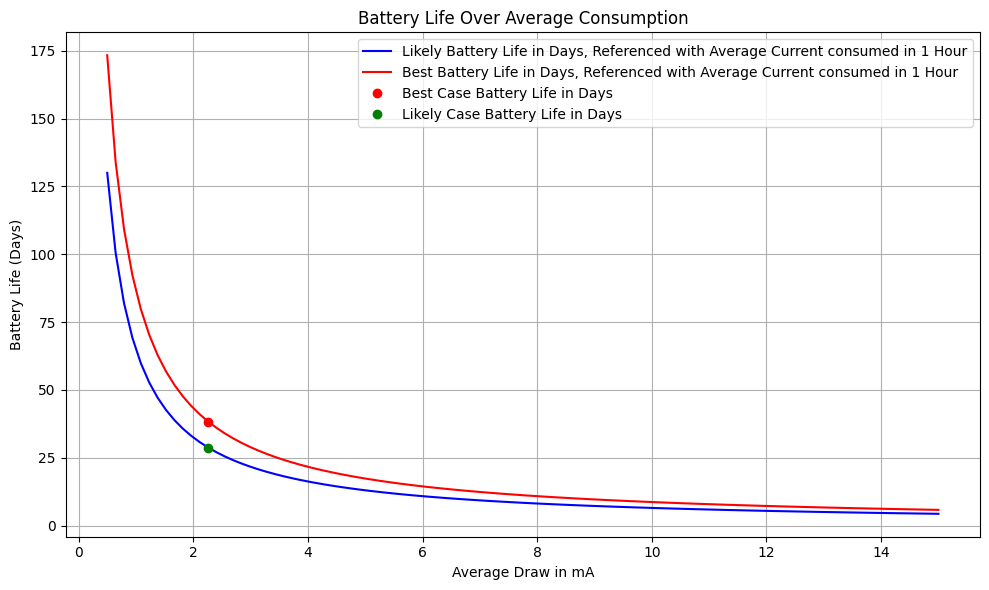

In [21]:
print("Let's verify the arrays first. First, the active draw over time. Then, the sleep draw over time.\n")
arrayprinter(power_array_active_time, 3)
arrayprinter(power_array_sleep_time, 3)
power_total_active_time = np.sum(power_array_active_time)
power_total_sleep_time = np.sum(power_array_sleep_time)
print("\nNow, let's calculate the total draw over time.")
print(f'The total active draw over time for one run is {power_total_active_time:.2f} mAh.')
print(f'The total sleep draw over time for one cycle is {power_total_sleep_time:.2f} mAh.')
average_power = (power_total_active_time + power_total_sleep_time) / (active_mode_time/(seconds_per_minute*minutes_per_hour) + deep_sleep_time/(seconds_per_minute*minutes_per_hour))
print(f'The average consumption is {(average_power):.2f} mA.\n')

# Let's compute the power budget over time in hours
# Formula: Estimated battery life = (Battery capacity in mAh) / (Total power consumption in mAh) * (1 - Safety margin)

best_case_battery_life = battery_capacity / (average_power) * (1.0 - battery_safety_margin)
likely_case_battery_life = (battery_capacity * 0.75) / (average_power) * (1.0 - battery_safety_margin)
print(f'The estimated "best case" battery life (accounting for 100% charge available, 20% safety margin) is,\n'
      f'{best_case_battery_life:.2f} hours, or {best_case_battery_life/24:.2f} days.')
# 6 hours of sleep, plus 0.0222 hours of active time (80 sec) per cycle
print(f'The estimated "likely case" battery life (accounting for 75% charge available, 20% safety margin) is,\n'
      f'{likely_case_battery_life:.2f} hours, or {likely_case_battery_life/24:.2f} days.\n')

# Let's plot the consumption over time
plt.figure(figsize=(10, 6))

x = np.linspace(0.5, 15, 100)# 100 cycles
z = ((battery_capacity)/(x) * (1.0 - battery_safety_margin))/24 * np.ones(100) # Best case battery life in days
y = ((battery_capacity*0.75)/(x) * (1.0 - battery_safety_margin))/24 * np.ones(100) # Likely case battery life in days
plt.plot(x, y, label='Likely Battery Life in Days, Referenced with Average Current consumed in 1 Hour', color='blue')
plt.plot(x, z, label='Best Battery Life in Days, Referenced with Average Current consumed in 1 Hour',color='red')
plt.plot(average_power, best_case_battery_life/24, 'ro', label='Best Case Battery Life in Days')
plt.plot(average_power, likely_case_battery_life/24, 'go', label='Likely Case Battery Life in Days')
plt.xlabel('Average Draw in mA')
plt.ylabel('Battery Life (Days)')
plt.title('Battery Life Over Average Consumption')
plt.legend()
plt.grid()
save_fig('battery_life_plot', tight_layout=True, fig_extension='png', resolution=300)
plt.show()

# Test1 Results

**_Post Test1 Analysis_**

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df_cloud_measurements = pd.read_csv('data.csv', sep=';', header=0)
#print(df_cloud_measurements.head())
print(df_cloud_measurements.describe())


             TDS       Temp  bootCounter  cycleTime         pH     rawTDS  \
count  20.000000  20.000000    20.000000  20.000000  20.000000  20.000000   
mean   14.014090  22.384375     4.650000  77.550000   5.313262  18.747054   
std     3.060237   0.481152     2.888726   1.050063   0.079576   2.887333   
min    11.843110  21.500000     1.000000  76.000000   5.196127  16.698740   
25%    12.598873  22.078125     2.000000  77.000000   5.235812  17.411798   
50%    13.022315  22.406250     4.500000  77.000000   5.307772  17.811315   
75%    14.145647  22.687500     7.000000  78.000000   5.371115  18.871180   
max    25.507380  23.312500    10.000000  80.000000   5.478631  29.590970   

       voltagePh  voltageTDS  
count  20.000000   20.000000  
mean    1.809872    0.042078  
std     0.012084    0.006517  
min     1.783500    0.036889  
25%     1.801125    0.039234  
50%     1.809375    0.040015  
75%     1.822500    0.042047  
max     1.824750    0.066275  


In [23]:
# Compute the number of cloud measurements
cloud_count = len(df_cloud_measurements)
print(f'The number of cloud measurements is {cloud_count}.\n')



The number of cloud measurements is 20.



In [24]:
df_sd_measurements = pd.read_csv('sd_data.csv', sep=';', header=0)
#print(df_sd_measurements.head())
print(df_sd_measurements.describe())

        finalTemp    finalTDS      rawTDS  voltageTDS     finalpH  voltagePh
count  900.000000  900.000000  900.000000  900.000000  900.000000  900.00000
mean    22.134589   13.234256   18.011511    0.040500    5.287767    1.81640
std      0.320997    1.924274    1.815456    0.004122    0.230298    0.03998
min     21.500000   11.840000   16.700000    0.040000   -1.490000    1.78000
25%     21.880000   12.590000   17.400000    0.040000    5.260000    1.81000
50%     22.090000   12.930000   17.720000    0.040000    5.280000    1.82000
75%     22.380000   13.420000   18.190000    0.040000    5.330000    1.82000
max     23.310000   53.420000   55.920000    0.130000    5.480000    3.00000


In [25]:
# Compute the number of SD measurements
offline_count = len(df_sd_measurements) - cloud_count
print(f'The number of offline measurements is {offline_count}.\n')

The number of offline measurements is 880.



In [26]:
# Compute the percentage of cloud measurements
cloud_percentage = (cloud_count / (cloud_count + offline_count)) * 100
print(f'The percentage of cloud measurements is {cloud_percentage:.2f} %.\n')

# Compute the percentage of offline measurements
offline_percentage = (offline_count / (cloud_count + offline_count)) * 100
print(f'The percentage of offline measurements is {offline_percentage:.2f} %.\n')

The percentage of cloud measurements is 2.22 %.

The percentage of offline measurements is 97.78 %.



In [27]:
df_time = pd.read_csv('sd_time.csv', sep=';', header=0)
#print(df_time.head())
print(df_time.describe())

       cycleSeconds  cycleMinutes  cycleHours  measurementCycle
count    899.000000     899.00000  899.000000        899.000000
mean     527.125695       8.78396    0.146434         50.592881
std     3165.029373      52.75071    0.879174          4.114318
min       49.000000       0.82000    0.013600         49.000000
25%       50.000000       0.83000    0.013900         50.000000
50%       50.000000       0.83000    0.013900         50.000000
75%       50.000000       0.83000    0.013900         50.000000
max    21574.000000     359.57000    5.992800         80.000000


In [28]:
time_count = len(df_time)
print(f'The number of time measurements is {time_count}.\n')
print(f'The time measurement dataframe computes the time difference between two measurements.\n')

The number of time measurements is 899.

The time measurement dataframe computes the time difference between two measurements.



In [29]:
# drop all rows where the measurementCycle is less than 70 (deep sleep only happens 
# when measurements are uploaded)
df_time_filtered_sleep = df_time.drop(df_time[df_time["measurementCycle"] < 70].index)

df_time_filtered_sleep["deepSleepCycle"] = df_time_filtered_sleep["cycleSeconds"] - df_time_filtered_sleep["measurementCycle"]


print(df_time_filtered_sleep["deepSleepCycle"].describe())
print(f'The mean sleep time is {df_time_filtered_sleep["deepSleepCycle"].mean():.2f} seconds.\n')
print(f'The mean sleep time is {df_time_filtered_sleep["deepSleepCycle"].mean()/60:.2f} minutes.\n')
print(f'The mean sleep time is {df_time_filtered_sleep["deepSleepCycle"].mean()/3600:.2f} hours.\n')
print(f'The total sleep time is {df_time_filtered_sleep["deepSleepCycle"].sum():.2f} seconds.\n')
print(f'The total sleep time is {df_time_filtered_sleep["deepSleepCycle"].sum()/60:.2f} minutes.\n')
print(f'The total sleep time is {df_time_filtered_sleep["deepSleepCycle"].sum()/3600:.2f} hours.\n')
print(f'The total sleep time is {df_time_filtered_sleep["deepSleepCycle"].sum()/3600/24:.2f} days.\n')

count       20.00000
mean     21420.15000
std        106.34664
min      21153.00000
25%      21447.00000
50%      21459.50000
75%      21476.25000
max      21497.00000
Name: deepSleepCycle, dtype: float64
The mean sleep time is 21420.15 seconds.

The mean sleep time is 357.00 minutes.

The mean sleep time is 5.95 hours.

The total sleep time is 428403.00 seconds.

The total sleep time is 7140.05 minutes.

The total sleep time is 119.00 hours.

The total sleep time is 4.96 days.



In [30]:
# We need to compute the total measurement time
measurement_time = df_time["measurementCycle"].sum()
print(f'The total measurement time is {measurement_time} seconds.\n')
print(f'The total measurement time is {measurement_time/60:.2f} minutes.\n')
print(f'The total measurement time is {measurement_time/3600:.2f} hours.\n')
print(f'The total measurement time is {measurement_time/3600/24:.2f} days.\n')

The total measurement time is 45483 seconds.

The total measurement time is 758.05 minutes.

The total measurement time is 12.63 hours.

The total measurement time is 0.53 days.



In [31]:
# We need to compute the total measurement time divided between uploaded measurements and offline measurements
measurement_time_cloud = df_cloud_measurements["cycleTime"].sum()
print(f'The total measurement time for cloud measurements is {measurement_time_cloud} seconds.\n')
print(f'The total measurement time for cloud measurements is {measurement_time_cloud/60:.2f} minutes.\n')
print(f'The total measurement time for cloud measurements is {measurement_time_cloud/3600:.2f} hours.\n')
print(f'The total measurement time for cloud measurements is {measurement_time_cloud/3600/24:.2f} days.\n')

# Print separator
print("--------------------------------------------------\n")
# We need to compute the total measurement time for offline measurements

df_measurement_time_offline = df_time.drop(df_time[df_time["measurementCycle"] > 70].index)
measurement_time_offline = df_measurement_time_offline["measurementCycle"].sum()
print(f'The total measurement time for offline measurements is {measurement_time_offline} seconds.\n')
print(f'The total measurement time for offline measurements is {measurement_time_offline/60:.2f} minutes.\n')
print(f'The total measurement time for offline measurements is {measurement_time_offline/3600:.2f} hours.\n')
print(f'The total measurement time for offline measurements is {measurement_time_offline/3600/24:.2f} days.\n')

The total measurement time for cloud measurements is 1551 seconds.

The total measurement time for cloud measurements is 25.85 minutes.

The total measurement time for cloud measurements is 0.43 hours.

The total measurement time for cloud measurements is 0.02 days.

--------------------------------------------------

The total measurement time for offline measurements is 43932 seconds.

The total measurement time for offline measurements is 732.20 minutes.

The total measurement time for offline measurements is 12.20 hours.

The total measurement time for offline measurements is 0.51 days.



In [32]:
# Compute the total runtime (active + sleep)
total_runtime = df_time["cycleHours"].sum()
print(f'The total runtime is {total_runtime} hours.\n')
print(f'The total runtime is {total_runtime/24:.2f} days.\n')

The total runtime is 131.64439999999996 hours.

The total runtime is 5.49 days.

